In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns

In [2]:

sns.set(style = 'white', font_scale = 2)

In [3]:


tesla = pd.read_csv('TSLA.csv') 
tesla_np = tesla.to_numpy()

google = pd.read_csv('GOOGL.csv') 
google_np = google.to_numpy()

dji = pd.read_csv('DJI.csv') 
dji_np = dji.to_numpy()

In [4]:


#importing the standard scalar function
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

#select only the closing data column, reshape to be able to run through standard scalar
selected=google_np[:,4].reshape(-1,1)
normalized=scaler.fit_transform(selected)

#find out how many days are in the whole array
print(normalized.size)
#to be able to select all but last 100 days
train_data=normalized[:3602]
train_data.shape

3702


(3602, 1)

In [5]:


encoder_inputseq_len = 10 
decoder_outputseq_len = 4
testing_sequence_len = 50


def generate_input_output_seqs(train_data, encoder_inputseq_len, decoder_outputseq_len, stride = 1, num_features = 1):
  
    #find the length of the data set
    L = train_data.shape[0]  
    
    # use the formula to calculate how many samples we will take based on the encoder/decoder length and stride
    num_samples = (L - encoder_inputseq_len - decoder_outputseq_len) // stride + 1
    
    # empty arrays to contain the sequences
    train_input_seqs = np.zeros([num_samples, encoder_inputseq_len, num_features])
    train_output_seqs = np.zeros([num_samples, decoder_outputseq_len, num_features])    
    
    # fill up the array
    for ff in np.arange(num_features):
        
        for ii in np.arange(num_samples):
            
            start_x = stride * ii
            end_x = start_x + encoder_inputseq_len
            train_input_seqs[ii, :, ff] = train_data[start_x:end_x, ff]
            
            print(train_input_seqs.shape)

            start_y = stride * ii + encoder_inputseq_len
            end_y = start_y + decoder_outputseq_len 
            train_output_seqs[ii, :, ff] = train_data[start_y:end_y, ff]

    return train_input_seqs, train_output_seqs

train_input_seqs, train_output_seqs = generate_input_output_seqs(train_data = train_data,
                                                                 encoder_inputseq_len = encoder_inputseq_len,
                                                                 decoder_outputseq_len = decoder_outputseq_len,
                                                                 stride = 1,
                                                                 num_features = 1)

(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589, 10, 1)
(3589,

In [6]:


print("Encoder Training Inputs Shape: ", train_input_seqs.shape)
print("Decoder Training Outputs Shape: ", train_output_seqs.shape)

Encoder Training Inputs Shape:  (3589, 10, 1)
Decoder Training Outputs Shape:  (3589, 4, 1)


In [11]:
class Encoder(torch.nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        
        super(Encoder, self).__init__()
        
        #lstm model with batch size for the encoder
        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                                  num_layers = num_layers, 
                                  batch_first = True)
        
    def forward(self, input_seq, hidden_state):
        
        out, hidden = self.lstm(input_seq, hidden_state)
        
        return out, hidden     

class Decoder(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        
        super(Decoder, self).__init__()

        #lstm and fully connected network for the decoder so that we get a single output

        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                                  num_layers = num_layers,
                                  batch_first = True)
        
        self.fc_decoder = torch.nn.Linear(hidden_size, output_size)  

    def forward(self, input_seq, encoder_hidden_states):
        
        out, hidden = self.lstm(input_seq, encoder_hidden_states)
        out = self.fc_decoder(out)
        
        return out, hidden

    #combine the two into one model
class Encoder_Decoder(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, decoder_output_size, num_layers):

        super(Encoder_Decoder, self).__init__()

        self.Encoder = Encoder(input_size = input_size, hidden_size = hidden_size, 
                               num_layers = num_layers)
        
        self.Decoder = Decoder(input_size = input_size, hidden_size = hidden_size, 
                               output_size = decoder_output_size, num_layers = num_layers)

In [18]:
torch.manual_seed(2)

input_size=1
hidden_size=15
decoder_output_size=1
num_layers=1

model = Encoder_Decoder(input_size=input_size, hidden_size=hidden_size,
                        decoder_output_size=decoder_output_size, num_layers=num_layers)


learning_rate = 0.005    
epochs = 20

batchsize = 10
num_features = train_output_seqs.shape[2]

loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model

Encoder_Decoder(
  (Encoder): Encoder(
    (lstm): LSTM(1, 15, batch_first=True)
  )
  (Decoder): Decoder(
    (lstm): LSTM(1, 15, batch_first=True)
    (fc_decoder): Linear(in_features=15, out_features=1, bias=True)
  )
)

In [19]:
train_loss_list = []

In [20]:
# Convert training data into torch tensors

train_input_seqs = torch.from_numpy(train_input_seqs).float()
train_output_seqs = torch.from_numpy(train_output_seqs).float()

# Split training data into mini-batches

train_batches_features = torch.split(train_input_seqs, batchsize)[:-1]
train_batches_targets = torch.split(train_output_seqs, batchsize)[:-1]

# Compute total number of mini-batches in training data

batch_split_num = len(train_batches_features)

In [23]:
for epoch in range(epochs): 
    
    for k in range(batch_split_num): 
        
        # initialize hidden states
        hidden_state = None
        
        # initialize empty torch tensor array to store decoder output sequence
        decoder_output_seq = torch.zeros(batchsize, decoder_outputseq_len, num_features)
        
        # empty gradient buffer
        optimizer.zero_grad()
        
        # Feed k-th mini-batch for encoder input sequences to encoder with hidden state
        encoder_output, encoder_hidden = model.Encoder(train_batches_features[k], hidden_state)
        # Re-define the resulting encoder hidden states as input hidden states to decoder
        decoder_hidden = encoder_hidden
        
        # Initial input to decoder is last timestep feature from the encoder input sequence
        decoder_input = train_batches_features[k][:, -1, :]
        # The extracted feature is 2D so need to add additional 3rd dimension 
        # to conform to (sample size, seq_len, # of features)
        decoder_input = torch.unsqueeze(decoder_input, 2)
        
        # Populating the decoder output sequence
        for t in range(decoder_outputseq_len): # for each timestep in output sequence
            
            # Feed in the decoder_input and decoder_hidden to Decoder, get new output and hidden states
            decoder_output, decoder_hidden = model.Decoder(decoder_input, decoder_hidden)
            
            # Populate the corresponding timestep in decoder output sequence 
            decoder_output_seq[:, t, :] = torch.squeeze(decoder_output, 2)
            
            # We are using teacher forcing so using the groundtruth training target as the next input        
            decoder_input = train_batches_targets[k][:, t, :]
            
            # The extracted feature is 2D so need to add additional 3rd dimension 
            # to conform to (sample size, seq_len, # of features)
            decoder_input = torch.unsqueeze(decoder_input, 2)
        
        # Compare the predicted decoder output sequence aginast the target sequence to compute the MSE loss
        loss = loss_func(torch.squeeze(decoder_output_seq), torch.squeeze(train_batches_targets[k]))
        
        # Save the loss
        train_loss_list.append(loss.item())
        
        # Backprop
        loss.backward()
        
        # Update the RNN
        optimizer.step()
    
    print("Averaged Training Loss for Epoch ", epoch,": ", np.mean(train_loss_list[-batch_split_num:]))

Averaged Training Loss for Epoch  0 :  0.06434944607385736
Averaged Training Loss for Epoch  1 :  0.052858319787685626
Averaged Training Loss for Epoch  2 :  0.038558999484914806
Averaged Training Loss for Epoch  3 :  0.0179218248592289
Averaged Training Loss for Epoch  4 :  0.01033762584343831
Averaged Training Loss for Epoch  5 :  0.007925707936772585
Averaged Training Loss for Epoch  6 :  0.00677840318218318
Averaged Training Loss for Epoch  7 :  0.0060518078601962365
Averaged Training Loss for Epoch  8 :  0.005540630411881126
Averaged Training Loss for Epoch  9 :  0.005122647452750324
Averaged Training Loss for Epoch  10 :  0.004820913750239793
Averaged Training Loss for Epoch  11 :  0.004588924551654351
Averaged Training Loss for Epoch  12 :  0.004392188462477038
Averaged Training Loss for Epoch  13 :  0.004222444668563419
Averaged Training Loss for Epoch  14 :  0.004075484442319828
Averaged Training Loss for Epoch  15 :  0.00393688005742813
Averaged Training Loss for Epoch  16 : 

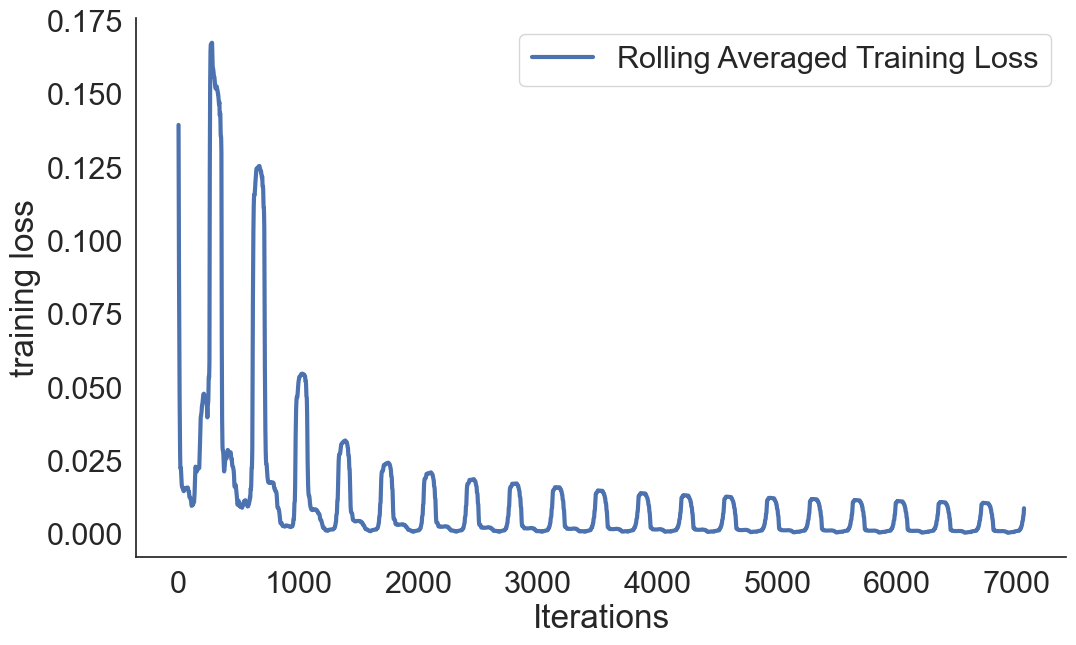

In [24]:
plt.figure(figsize = (12, 7))

plt.plot(np.convolve(train_loss_list, np.ones(100), 'valid') / 100, 
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()

In [25]:
# Define your testing sequence

test_input_seq = train_data[-testing_sequence_len:]

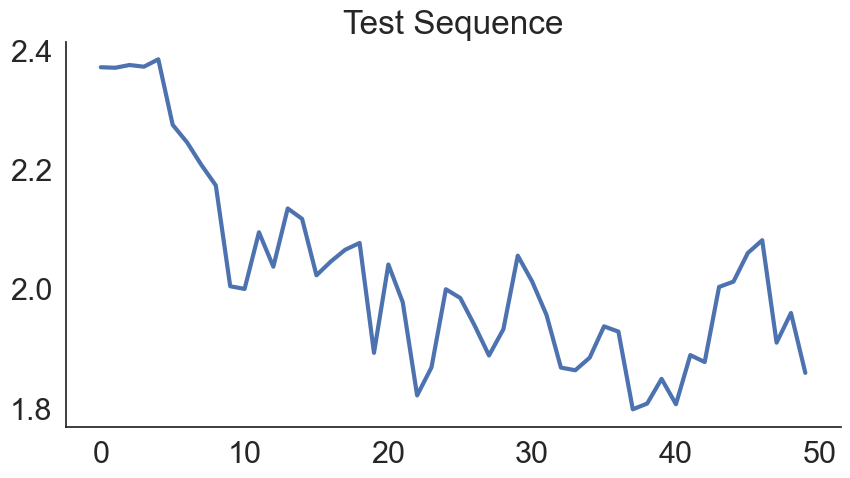

In [26]:
# We can visualize the testing sequence

plt.figure(figsize = (10, 5))
plt.plot(test_input_seq, linewidth = 3)
plt.title('Test Sequence')
sns.despine()

In [29]:


# Convert test sequence to tensor
test_input_seq = torch.from_numpy(test_input_seq).float()

# initialize empty torch tensor array to store decoder output sequence
decoder_output_seq = torch.zeros(testing_sequence_len, num_features)

decoder_output_seq[:encoder_inputseq_len] = test_input_seq[:encoder_inputseq_len]

# Initialize index for prediction
pred_start_ind = 0

# Activate no_grad() since we aren't performing backprop
with torch.no_grad():
    
    # Loop continues until the RNN prediction reaches the end of the testing sequence length
    while pred_start_ind + encoder_inputseq_len + decoder_outputseq_len < testing_sequence_len:
        
        # initialize hidden state for encoder
        hidden_state = None
        
        # Define the input to encoder
        input_test_seq = decoder_output_seq[pred_start_ind:pred_start_ind + encoder_inputseq_len]
        # Add dimension to first dimension to keep the input (sample_size, seq_len, # of features/timestep)
        input_test_seq = torch.unsqueeze(input_test_seq, 0)
        
        # Feed the input to encoder and set resulting hidden states as input hidden states to decoder
        encoder_output, encoder_hidden = model.Encoder(input_test_seq, hidden_state)
        decoder_hidden = encoder_hidden
        
        # Initial input to decoder is last timestep feature from the encoder input sequence 
        decoder_input = input_test_seq[:, -1, :]
        # Add dimension to keep the input (sample_size, seq_len, # of features/timestep)
        decoder_input = torch.unsqueeze(decoder_input, 2)
        
        # Populate decoder output sequence
        for t in range(decoder_outputseq_len):
            
            #use the ground truth value as the input for the decoder regardless of the encoder output
            decoder_input = torch.unsqueeze(test_input_seq[pred_start_ind+encoder_inputseq_len+t],0)
            decoder_input = torch.unsqueeze(decoder_input, 2)
            
            #generate a new ouput 
            decoder_output, decoder_hidden = model.Decoder(decoder_input, decoder_hidden)
            #populate the timestep
            decoder_output_seq[pred_start_ind+encoder_inputseq_len+t]=torch.squeeze(decoder_output)
            
        
        # Update pred_start_ind
        pred_start_ind += decoder_outputseq_len

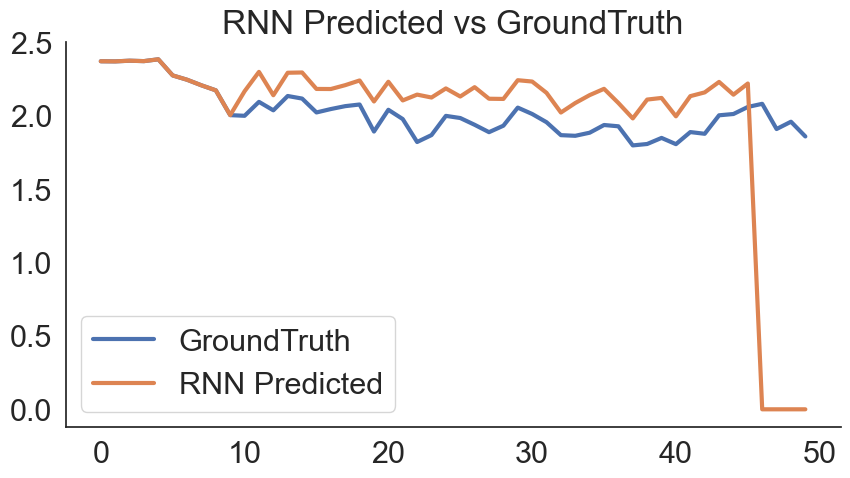

In [30]:


plt.figure(figsize = (10, 5))

plt.plot(test_input_seq, linewidth = 3, label = 'GroundTruth')
plt.plot(decoder_output_seq, linewidth = 3, label = 'RNN Predicted')
plt.title('RNN Predicted vs GroundTruth')
plt.legend()
sns.despine()

In [31]:


mse_error = torch.mean(torch.pow(test_input_seq - decoder_output_seq, 2))
print("Test MSE Error:", mse_error.item())


Test MSE Error: 0.3358553946018219
